In [1]:
# Imports 
import pandas as pd
from sklearn.impute import KNNImputer
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2021-09-08 09:52:17.795171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-08 09:52:17.795671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Importing data 

In [2]:
df = pd.read_csv('stationary_data.csv')

In [47]:
df.head()

,start,close_price,tweet_count,twitter_sentiment,volume,volatility,rsi,macd,reddit_sentiment,reddit_post_count
0,2018-01-03,-0.078084,0.068450,6.096648,2.529997e+07,-0.141918,0.016552,30.100003,0.213028,-104.0
1,2018-01-04,0.011353,-0.066855,4.738479,4.911300e+09,-0.021054,0.030055,53.719591,-0.833220,-17.0
2,2018-01-05,0.085086,-0.084542,5.809624,2.057699e+09,0.243666,0.114442,185.854342,0.342103,48.0
3,2018-01-06,-0.105366,-0.246690,6.643630,-5.526299e+09,0.163605,0.005255,149.031677,-0.065387,-185.0
4,2018-01-07,-0.067319,0.091045,8.091246,-2.448600e+09,0.006811,-0.090538,26.993014,0.184959,53.0


# Imputer 

In [3]:
imputer = KNNImputer(n_neighbors=2)
df['reddit_sentiment'],df['reddit_post_count'],df['twitter_sentiment'] = imputer.fit_transform(df[['reddit_sentiment','reddit_post_count','twitter_sentiment']]).T

# Train Test Val Split

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Standardize

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_13235/1429736173.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_mean = train_df.mean()
/tmp/ipykernel_13235/1429736173.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_std = train_df.std()


# Modelling

In [6]:
sequence_length = 7
train_df['target'] = train_df['close_price'].shift(-sequence_length)
train_df.drop('start', axis = 1, inplace = True)

In [7]:
train_df.dropna()

,close_price,macd,reddit_post_count,reddit_sentiment,rsi,tweet_count,twitter_sentiment,volatility,volume,target
0,-1.282915,0.659219,-1.244836,0.563656,0.145075,0.409370,0.708600,-0.820883,0.005212,1.056800
1,0.187977,1.176309,-0.190403,-2.187755,0.266023,-0.388832,-0.074973,-0.113681,1.203402,-2.237758
2,1.400588,4.069058,0.597392,0.903096,1.021837,-0.493172,0.543006,1.435256,0.503616,2.510337
3,-1.731595,3.262921,-2.226549,-0.168516,0.043896,-1.449731,1.024172,0.966801,-1.356202,-0.248610
4,-1.105872,0.591200,0.657991,0.489839,-0.814077,0.542666,1.859351,0.049367,-0.601460,-1.127149
...,...,...,...,...,...,...,...,...,...,...
893,0.058953,0.013762,-0.578240,-0.571180,-0.005860,0.982887,-1.434736,-0.163125,0.137616,-0.110625
894,-0.087907,-0.071556,0.645871,-1.534328,-0.360344,7.794126,-2.789252,0.042164,-0.550381,-0.164714
895,-0.017652,-0.155452,-1.305435,0.530168,-0.445726,-0.612211,-2.407624,-0.030022,-0.033059,-0.170655
896,0.144526,-0.080090,0.209554,1.456391,0.175874,-6.587683,-1.985591,-0.329861,-0.434900,0.317315


In [8]:
X_train = train_df.drop('target', axis = 1)
y_train = train_df['target']
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train, y_train, sequence_length=10, batch_size = 16)


2021-09-08 09:52:24.193509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-08 09:52:24.193774: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-08 09:52:24.193891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Omar-Laptop): /proc/driver/nvidia/version does not exist
2021-09-08 09:52:24.198860: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
exx, exxy = next(iter(dataset))
train_df.iloc[:10]
test_df['target'] = test_df['close_price'].shift(-sequence_length)


2021-09-08 09:52:24.883406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [10]:
sample_1 = pd.DataFrame(exx[0].numpy())

In [11]:
sample_1.columns = train_df.drop(columns = 'target').columns

In [12]:
sample_1

,close_price,macd,reddit_post_count,reddit_sentiment,rsi,tweet_count,twitter_sentiment,volatility,volume
0,-1.282915,0.659219,-1.244836,0.563656,0.145075,0.409370,0.708600,-0.820883,0.005212
1,0.187977,1.176309,-0.190403,-2.187755,0.266023,-0.388832,-0.074973,-0.113681,1.203402
2,1.400588,4.069058,0.597392,0.903096,1.021837,-0.493172,0.543006,1.435256,0.503616
3,-1.731595,3.262921,-2.226549,-0.168516,0.043896,-1.449731,1.024172,0.966801,-1.356202
4,-1.105872,0.591200,0.657991,0.489839,-0.814077,0.542666,1.859351,0.049367,-0.601460
5,-0.343035,-1.959509,2.572938,0.280390,-0.987329,1.151345,-0.668360,-0.184221,0.623827
6,0.725799,-2.655829,-1.281196,-0.540476,-0.433820,0.538181,0.855073,-0.026156,-0.431100
7,1.056800,-1.507488,-0.505521,1.080213,0.307582,0.209730,-0.650843,-0.044257,0.450426
8,-2.237758,-3.988060,1.118548,-1.073881,-1.205913,0.811707,0.019531,0.342525,-0.483284
9,2.510337,-2.144758,-2.299269,-0.547355,0.537809,-1.164093,1.101803,0.122919,-1.096774


In [13]:
train_df.head(10)

,close_price,macd,reddit_post_count,reddit_sentiment,rsi,tweet_count,twitter_sentiment,volatility,volume,target
0,-1.282915,0.659219,-1.244836,0.563656,0.145075,0.409370,0.708600,-0.820883,0.005212,1.056800
1,0.187977,1.176309,-0.190403,-2.187755,0.266023,-0.388832,-0.074973,-0.113681,1.203402,-2.237758
2,1.400588,4.069058,0.597392,0.903096,1.021837,-0.493172,0.543006,1.435256,0.503616,2.510337
3,-1.731595,3.262921,-2.226549,-0.168516,0.043896,-1.449731,1.024172,0.966801,-1.356202,-0.248610
4,-1.105872,0.591200,0.657991,0.489839,-0.814077,0.542666,1.859351,0.049367,-0.601460,-1.127149
5,-0.343035,-1.959509,2.572938,0.280390,-0.987329,1.151345,-0.668360,-0.184221,0.623827,0.746063
6,0.725799,-2.655829,-1.281196,-0.540476,-0.433820,0.538181,0.855073,-0.026156,-0.431100,-3.091359
7,1.056800,-1.507488,-0.505521,1.080213,0.307582,0.209730,-0.650843,-0.044257,0.450426,2.599016
8,-2.237758,-3.988060,1.118548,-1.073881,-1.205913,0.811707,0.019531,0.342525,-0.483284,0.854676
9,2.510337,-2.144758,-2.299269,-0.547355,0.537809,-1.164093,1.101803,0.122919,-1.096774,-0.225464


In [14]:
exxy[0].numpy()

1.056799714593014

In [15]:
test_df.drop('start', axis = 1, inplace = True)

In [16]:
X_test = test_df.drop('target', axis = 1)
y_test = test_df['target']



In [17]:
dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test, y_test, sequence_length=10)


In [18]:
etx, ety = next(iter(dataset_test))
val_df['target'] = val_df['close_price'].shift(-sequence_length)
val_df.drop('start', axis = 1, inplace = True)
X_val = val_df.drop('target', axis = 1)
y_val =val_df['target']
dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_val, y_val, sequence_length=10)
evx, evy = next(iter(dataset_val))

# Train model

In [19]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    #tf.keras.layers.Dropout(0.2),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=16),
    tf.keras.layers.Dense(units=1)
    # Adding a second LSTM layer and some Dropout regularisation
])

# regularization?
# GRU layer

In [20]:
lstm_model.compile(optimizer = 'Adam', loss = 'mae')

In [21]:
es = EarlyStopping(patience = 20, restore_best_weights=True)

In [22]:
reduce_lr = ReduceLROnPlateau(patience = 15)

In [23]:
lstm_model.fit(dataset, validation_data = dataset_val, epochs = 2_000, callbacks = [es, reduce_lr])

Epoch 1/2000
56/56 [==============================] - 23s 137ms/step - loss: 0.6683 - val_loss: 0.6363
Epoch 2/2000
56/56 [==============================] - 5s 88ms/step - loss: 0.6514 - val_loss: 0.6318
Epoch 3/2000
56/56 [==============================] - 5s 82ms/step - loss: 0.6407 - val_loss: 0.6320
Epoch 4/2000
56/56 [==============================] - 4s 74ms/step - loss: 0.5558 - val_loss: 0.4714
Epoch 5/2000
56/56 [==============================] - 4s 77ms/step - loss: 0.2096 - val_loss: 0.2993
Epoch 6/2000
56/56 [==============================] - 4s 66ms/step - loss: 0.1438 - val_loss: 0.3069
Epoch 7/2000
56/56 [==============================] - 3s 53ms/step - loss: 0.1364 - val_loss: 0.2847
Epoch 8/2000
56/56 [==============================] - 3s 54ms/step - loss: 0.1276 - val_loss: 0.2755
Epoch 9/2000
56/56 [==============================] - 3s 54ms/step - loss: 0.1027 - val_loss: 0.2536
Epoch 10/2000
56/56 [==============================] - 3s 54ms/step - loss: 0.0932 - val_

56/56 [==============================] - 5s 86ms/step - loss: 0.0406 - val_loss: 0.0967
Epoch 82/2000
56/56 [==============================] - 5s 90ms/step - loss: 0.0391 - val_loss: 0.1155
Epoch 83/2000
56/56 [==============================] - 5s 89ms/step - loss: 0.0493 - val_loss: 0.0841
Epoch 84/2000
56/56 [==============================] - 5s 91ms/step - loss: 0.0454 - val_loss: 0.1075
Epoch 85/2000
56/56 [==============================] - 4s 80ms/step - loss: 0.0431 - val_loss: 0.0755
Epoch 86/2000
56/56 [==============================] - 8s 138ms/step - loss: 0.0465 - val_loss: 0.1016
Epoch 87/2000
56/56 [==============================] - 6s 106ms/step - loss: 0.0439 - val_loss: 0.0994
Epoch 88/2000
56/56 [==============================] - 4s 74ms/step - loss: 0.0407 - val_loss: 0.0886
Epoch 89/2000
56/56 [==============================] - 4s 74ms/step - loss: 0.0361 - val_loss: 0.0868
Epoch 90/2000
56/56 [==============================] - 4s 74ms/step - loss: 0.0311 - val_loss:

Epoch 161/2000
56/56 [==============================] - 2s 44ms/step - loss: 0.0047 - val_loss: 0.0600
Epoch 162/2000
56/56 [==============================] - 2s 44ms/step - loss: 0.0046 - val_loss: 0.0599
Epoch 163/2000
56/56 [==============================] - 3s 45ms/step - loss: 0.0046 - val_loss: 0.0600
Epoch 164/2000
56/56 [==============================] - 3s 45ms/step - loss: 0.0046 - val_loss: 0.0601
Epoch 165/2000
56/56 [==============================] - 3s 61ms/step - loss: 0.0046 - val_loss: 0.0599
Epoch 166/2000
56/56 [==============================] - 4s 70ms/step - loss: 0.0045 - val_loss: 0.0600
Epoch 167/2000
56/56 [==============================] - 4s 73ms/step - loss: 0.0045 - val_loss: 0.0598
Epoch 168/2000
56/56 [==============================] - 5s 97ms/step - loss: 0.0044 - val_loss: 0.0596
Epoch 169/2000
56/56 [==============================] - 4s 68ms/step - loss: 0.0044 - val_loss: 0.0598
Epoch 170/2000
56/56 [==============================] - 4s 68ms/step - lo

In [46]:
X_train.tail()

,close_price,macd,reddit_post_count,reddit_sentiment,rsi,tweet_count,twitter_sentiment,volatility,volume
900,-0.110625,0.558168,0.064115,-1.168413,0.830402,0.364181,-1.762147,1.154331,-0.377990
901,-0.164714,0.533461,-0.178283,-0.153201,0.257786,0.391031,-2.600100,1.638994,0.394843
902,-0.170655,0.333580,0.379233,0.887597,-0.357159,-0.221532,-2.638534,0.721922,-0.391797
903,0.317315,0.495218,-0.299482,0.670237,0.646585,-0.703370,-2.331410,1.073531,0.013060
904,0.144290,0.769609,0.464073,-1.308545,0.767258,-0.006306,-1.020457,1.565271,0.954893


In [24]:
lstm_model.evaluate(dataset_test)

1/1 [==============================] - 0s 230ms/step - loss: 0.1042


0.104178786277771

In [25]:
y_pred = lstm_model.predict(dataset_test)

In [26]:
etx, ety = next(iter(dataset_test))

In [27]:
y_test = ety.numpy()

In [28]:
y_pred = y_pred*train_std['close_price']+train_mean['close_price']

In [44]:
(y_pred >0).flatten().mean()

0.48760330578512395

In [29]:
y_test = y_test*train_std['close_price']+train_mean['close_price']

In [45]:
len(y_test)

121

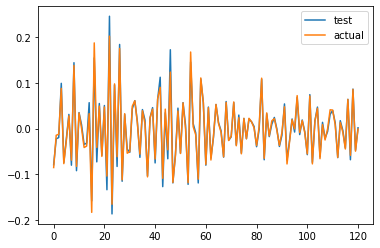

In [30]:
plt.plot(y_test, label = 'test')
plt.plot(y_pred, label = 'actual')
plt.legend()

In [31]:
((y_pred.flatten() > 0) == (y_test>0)).mean()

0.9752066115702479

In [32]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 128)         53376     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 93,249
Trainable params: 93,249
Non-trainable params: 0
_________________________________________________________________


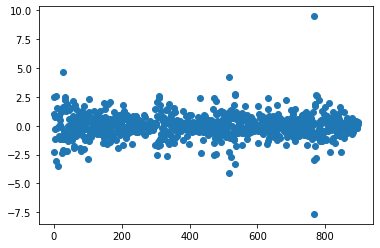

In [36]:
plt.scatter(x = range(len(train_df)), y = train_df.target)